# Your Title Here

**Name(s)**: Lauren May and Julia Rehring

**Website Link**: (your website link)

In [4]:
import pandas as pd
import numpy as np

import plotly.express as px
pd.options.plotting.backend = 'plotly'

from lec_utils import * # Feel free to uncomment and use this. It'll make your plotly graphs look like ours in lecture!

## Step 1: Introduction

In [110]:
outages = pd.read_excel('outage.xlsx', skiprows=[0,1,2,3,4,6], usecols=lambda x: x not in ['variables', 'OBS'])
outages

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,...,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,2011,7.0,Minnesota,MN,...,0.60,91.59,8.41,5.48
1,2014,5.0,Minnesota,MN,...,0.60,91.59,8.41,5.48
2,2010,10.0,Minnesota,MN,...,0.60,91.59,8.41,5.48
...,...,...,...,...,...,...,...,...,...
1531,2009,8.0,South Dakota,SD,...,0.15,98.31,1.69,1.69
1532,2009,8.0,South Dakota,SD,...,0.15,98.31,1.69,1.69
1533,2000,NaN,Alaska,AK,...,0.02,85.76,14.24,2.90


## Step 2: Data Cleaning and Exploratory Data Analysis

In [111]:
outages['OUTAGE.START.TIME'] = pd.to_timedelta(outages['OUTAGE.START.TIME'].astype(str))
outages['OUTAGE.START'] = outages['OUTAGE.START.DATE'] + outages['OUTAGE.START.TIME']
outages.drop(columns=['OUTAGE.START.DATE', 'OUTAGE.START.TIME'], inplace=True)

outages['OUTAGE.RESTORATION.TIME'] = pd.to_timedelta(outages['OUTAGE.RESTORATION.TIME'].astype(str))
outages['OUTAGE.RESTORATION'] = outages['OUTAGE.RESTORATION.DATE'] + outages['OUTAGE.RESTORATION.TIME']
outages.drop(columns=['OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME'], inplace=True)

In [112]:
outages = outages.dropna(subset=['MONTH', 'OUTAGE.DURATION'])

In [113]:
outages = outages[outages['OUTAGE.DURATION'] < 60_000]

In [114]:
nan_counts = outages.isna().sum()
print(nan_counts)

YEAR                  0
MONTH                 0
U.S._STATE            0
                     ..
PCT_WATER_INLAND      0
OUTAGE.START          0
OUTAGE.RESTORATION    0
Length: 53, dtype: int64


In [115]:
outages['CAUSE.CATEGORY'].value_counts()
outages_grouped = outages.groupby("CAUSE.CATEGORY", as_index=False).agg({
    "OUTAGE.DURATION": "mean",
    "CUSTOMERS.AFFECTED": "sum"
})
outages_grouped

,CAUSE.CATEGORY,OUTAGE.DURATION,CUSTOMERS.AFFECTED
0,equipment failure,399.13,2.84e+06
1,fuel supply emergency,9535.00,1.00e+00
2,intentional attack,429.98,3.56e+05
3,islanding,200.55,2.10e+05
4,public appeal,1468.45,1.60e+05
5,severe weather,3883.99,1.32e+08
6,system operability disruption,728.87,1.71e+07


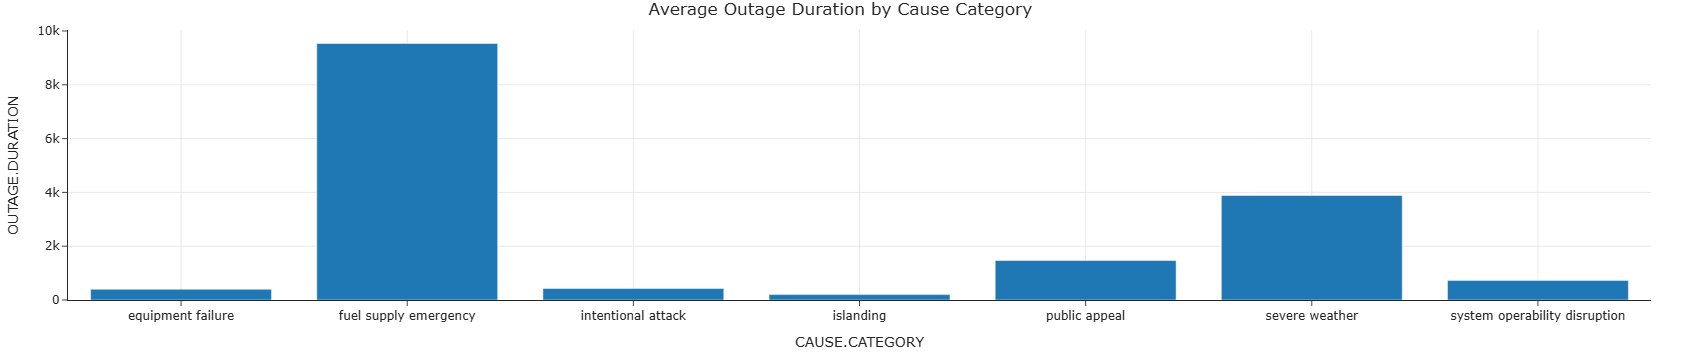

In [116]:
fig1 = px.bar(
    outages_grouped, 
    x="CAUSE.CATEGORY", 
    y="OUTAGE.DURATION", 
    title="Average Outage Duration by Cause Category"
)
fig1.show()

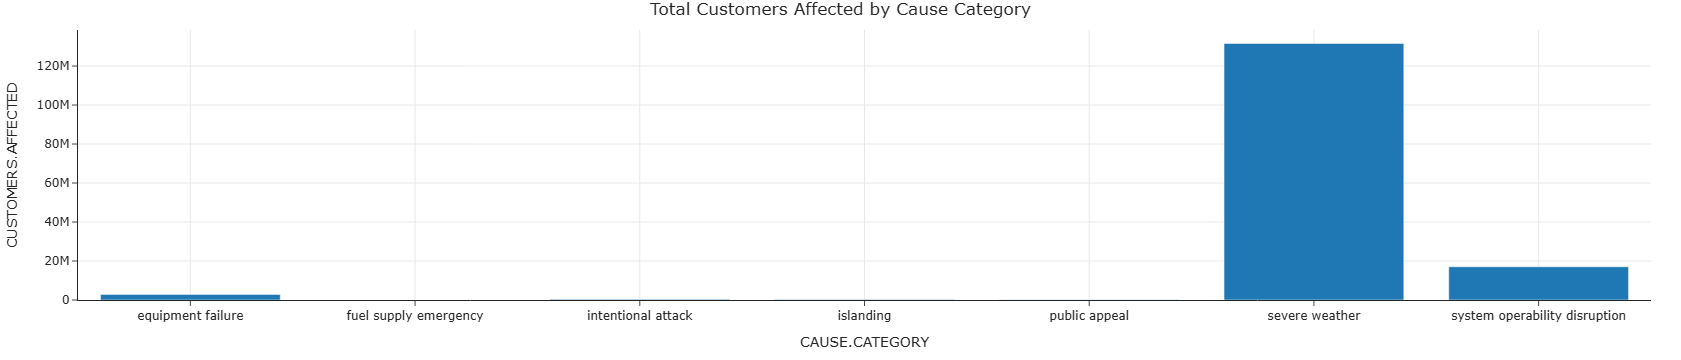

In [117]:
fig2 = px.bar(
    outages_grouped, 
    x="CAUSE.CATEGORY", 
    y="CUSTOMERS.AFFECTED", 
    title="Total Customers Affected by Cause Category"
)
fig2.show()

## Step 3: Framing a Prediction Problem

In [118]:
# TODO

## Step 4: Baseline Model

In [119]:
# TODO
# linear regression with cause category (OHE), month (OHE), and climate region (OHE)
from sklearn.pipeline import make_pipeline, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

features = outages[['MONTH', 'CLIMATE.REGION', 'CAUSE.CATEGORY', 'ANOMALY.LEVEL', 'CLIMATE.CATEGORY']]
duration = outages['OUTAGE.DURATION']

# make train-test split
X_train, X_test, y_train, y_test = train_test_split(features, duration, random_state=42)

absolute_anomaly = FunctionTransformer(lambda s: np.abs(s))

# OHE ['MONTH', 'CLIMATE.REGION', 'CAUSE.CATEGORY']
preprocessing = make_column_transformer(
    (OneHotEncoder(drop='first'), ['MONTH', 'CLIMATE.REGION', 'CAUSE.CATEGORY', 'CLIMATE.CATEGORY']),
    (absolute_anomaly, ['ANOMALY.LEVEL'])
)
model = make_pipeline(
    preprocessing,
    LinearRegression()
)

model.fit(X_train, y_train)

model.predict(pd.DataFrame({
    'MONTH': [7],
    'CLIMATE.REGION': 'Central',
    'CAUSE.CATEGORY': 'severe weather',
    'ANOMALY.LEVEL': 1.1,
    'CLIMATE.CATEGORY': 'cold'
}))

array([2133.79])

In [144]:
# Display all rows
pd.set_option('display.max_rows', None)

squared_errors = pd.DataFrame({
    'Predicted Duration': model.predict(X_train),
    'Actual Duration': y_train,
    'Cause': X_train['CAUSE.CATEGORY'],
    'Climate Region': X_train['CLIMATE.REGION'],
    'Squared Error':(y_train - model.predict(X_train)) ** 2
})
squared_errors.sort_values(by='Squared Error', ascending=False).head(10)

,Predicted Duration,Actual Duration,Cause,Climate Region,Squared Error
513,5244.62,49320.0,severe weather,Southwest,1.94e+09
499,5244.62,49320.0,severe weather,Southwest,1.94e+09
117,5197.28,46080.0,severe weather,East North Central,1.67e+09
1207,8741.60,49427.0,fuel supply emergency,West,1.66e+09
1181,5131.36,34390.0,severe weather,West,8.56e+08
268,6977.60,27698.0,severe weather,South,4.29e+08
202,6977.60,27698.0,severe weather,South,4.29e+08
1057,4523.08,24780.0,severe weather,Southeast,4.10e+08
911,1261.13,21360.0,intentional attack,East North Central,4.04e+08
333,3856.63,23773.0,severe weather,Central,3.97e+08


In [145]:
# training MSE
mean_squared_error(y_train, model.predict(X_train))

18854853.31760067

In [146]:
# validation MSE
mean_squared_error(y_test, model.predict(X_test))

10590620.78997313

In [75]:
mean_absolute_error(y_test, model.predict(X_test))

2139.70436713714

## Step 5: Final Model

In [26]:
# add grid search for polynomial features, compare Linear, Ridge, and LASSO